# Machine learning: exam assignment
### Predicting Marvel vs DC

#### Student: Jeroen Van Sweeveldt

### 1.1 Data exploration

In [1]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/University/machine_learning/exam

Mounted at /content/gdrive
/content/gdrive/MyDrive/University/machine_learning/exam


In [74]:
# imports for data exploration
import numpy as np
import pandas as pd
# imports for data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# imports for nn utilities
import import_ipynb
import utils

import random

# imports for neural classifier
import torch
import torchtext
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

torch.manual_seed(32)
np.random.seed(32)

import sklearn
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
print(sklearn.__version__)

1.0.2


In [190]:
heroes = pd.read_csv("superheroes_nlp_dataset.csv")

In [ ]:
heroes.sample(10)

,name,real_name,full_name,overall_score,history_text,powers_text,intelligence_score,strength_score,speed_score,durability_score,...,has_flight,has_accelerated_healing,has_weapons_master,has_intelligence,has_reflexes,has_super_speed,has_durability,has_stamina,has_agility,has_super_strength
908,Mohinder Suresh,Mohinder Suresh,Mohinder Suresh,-,Dr. Mohinder Suresh is a genetics professor fr...,Mohinder has acquired an ability by injecting...,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
598,Hinata Hyūga,Hinata Hyūga,NaN,9,Hinata Uzumakiis a kunoichi and the former hei...,NaN,90,10,70,60,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
204,Blizzard II,Donald Gill,Donald Gill,4,Donnie Gill was working as a minor hired thug ...,The Blizzard battlesuit contains cryogenic cir...,70,10,25,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1071,Red Mist,Chris Genovese,Chris Genovese,3,The Red Mist was another teenager following th...,NaN,65,10,25,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
207,Blob (FOX),Fred Dukes,Frederick J. Dukes,6,"During the Vietnam War in mid-late 1973, Fred ...",Blob's body possesses a high degree of resista...,80,30,30,85,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
333,Curse,Phillip Krahn,Phillip Krahn,-,"The Curse, born Phillip Krahn, has been fairly...",NaN,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
727,Kefla,Kale/Caulifla,Kale/Caulifla,17,With the Potara earrings given to Caulifla and...,"According to Vados, Kefla's power consists of...",85,100,100,100,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
215,Blue Beetle (Injustice),Jaime Reyes,Jaime Reyes,10,"Jaime Reyes is the Blue Beetle, a superhero an...",With the Scarab Jaime can produce a suit of a...,75,35,90,85,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
192,Black Mamba,Tanya Sealy,Tanya Sealy,8,Tanya Sealy was born in Chicago. She was an ex...,Black Mamba possesses the ability to project ...,90,10,35,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151,Ben 10,Benjamin Kirby Tennyson,Benjamin Kirby Tennyson,32,"When ten year old Ben Tennyson, his cousin Gwe...",NaN,90,100,100,100,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


The first thing we notice from the dataset is that the entries are not limited to the Marvel and DC universes: the first entry that comes up in the random sample is Mohinder Suresh, who is a character from the series "Heroes" (which had an amazing first season), and not tied to either one (talk about my geeky background coming in handy!).

We will have to seek out possible entries in the dataset that provide more insight as to which each character belongs first.

In [157]:
heroes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 81 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   name                              1448 non-null   object 
 1   real_name                         1301 non-null   object 
 2   full_name                         956 non-null    object 
 3   overall_score                     1450 non-null   object 
 4   history_text                      1360 non-null   object 
 5   powers_text                       1086 non-null   object 
 6   intelligence_score                1450 non-null   int64  
 7   strength_score                    1450 non-null   int64  
 8   speed_score                       1450 non-null   int64  
 9   durability_score                  1450 non-null   int64  
 10  power_score                       1450 non-null   int64  
 11  combat_score                      1450 non-null   int64  
 12  superp

In [191]:
heroes = heroes[["history_text", "creator"]]

In [12]:
heroes.sample(10)

,history_text,creator
224,"Querl Dox, also known as Brainiac 5, is a Colu...",NaN
255,Captain America helped out the Guardians of th...,Marvel Comics
1357,The origin of Brunnhilde the Valkyrie remains ...,Marvel Comics
841,Malekith was the utterly cruel and malevolent ...,Marvel Comics
809,NaN,Marvel Comics
757,Koko met Garmadon in a war under the identity ...,Lego
776,Lagoon Boy originally from the underwater city...,DC Comics
218,A.S. Scarlet is professor of English literatur...,DC Comics
138,After witnessing the brutal murder of his pare...,Lego
81,Arcturus was General of the Anacondrai during ...,NaN


In [192]:
heroes = heroes[(heroes["creator"] == "Marvel Comics") | (heroes["creator"] == "DC Comics")]
heroes["creator"].sample(20)

1035    Marvel Comics
743         DC Comics
1415    Marvel Comics
267         DC Comics
993         DC Comics
545     Marvel Comics
130         DC Comics
842     Marvel Comics
423         DC Comics
889     Marvel Comics
1385    Marvel Comics
111     Marvel Comics
1427    Marvel Comics
896     Marvel Comics
626     Marvel Comics
1381        DC Comics
1164    Marvel Comics
1443    Marvel Comics
901         DC Comics
23      Marvel Comics
Name: creator, dtype: object

In [193]:
# as we have to make predictions based on "history_text", we'll have to check if there are empty values there.
null_h = heroes["history_text"].isnull().sum()
# let's also check the number of empty values for the "creator" column, just to make sure.
null_a = heroes["creator"].isnull().sum()

print(null_h)
print(null_a)
print(len(heroes))

62
0
1059


On 1059 total data points, 62 isn't much. It can be safe to simply drop the empty data points; using a KNN Imputer to calculate the mean of its nearest neighbours after the text has been vectorized may not be a sound idea, since our data is text based. In this case, I foresee that doing so will produce gibberish that has more risk of confusing the algorithm rather than helping it.

In [194]:
total = len(heroes)
subnet = total - null_h
net = subnet - null_a

print(f"Total: {total} \
    \nEmpty values text: {null_h} \
    \nEmpty values creator: {null_a} \
    \nRows with info: {net}")

Total: 1059     
Empty values text: 62     
Empty values creator: 0     
Rows with info: 997


We still have almost one thousand info points left. It can be safe to drop the data points with empty values. Using a KNN Imputer here may not be feasable, as the column we need for our predictions is text based; the imputer calculates the mean of its nearest neighbours, and can be useful for numeric values. But in the case of vectorized text, I foresee it will produce gibberish that has more risk of confusing the algorithm rather than helping it.

In [195]:
heroes = heroes.dropna(subset=["history_text"])
abs_diff = total - net

print(f"Remaining data points: {len(heroes)} \
    \nData loss: {round(abs_diff/((total + net)/2) * 100, 2)}%")

Remaining data points: 997     
Data loss: 6.03%


Marvel Comics    583
DC Comics        414
Name: creator, dtype: int64


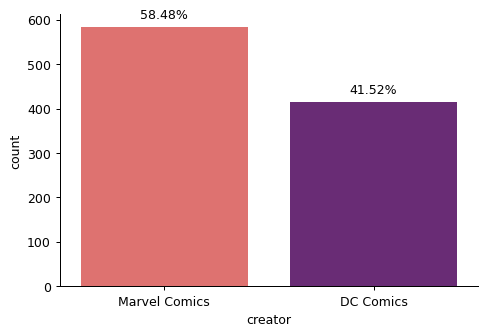

In [35]:
# let's check the balance of our classes to predict
print(heroes["creator"].value_counts())

# plot the counts for visual overview
plt.figure(dpi=90)
ax = sns.countplot(data=heroes, x="creator", palette="magma_r");
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# annotate plots with relative frequencies
for p in ax.patches:
    y=p.get_bbox().get_points()[1,1]       
    ax.annotate("{:.2f}%".format(100.*y/len(heroes)), (p.get_x() + p.get_width() / 2., p.get_height()),  
    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [17]:
heroes.history_text[2]

' Richard "Rick" Jones was orphaned at a young age, and after being expelled from several orphanages for disciplinary reasons he was placed into a state institution called Tempest Town. A troubled and rebellious youth, Jones soon came to the attention of the institution\'s chief administrator who smashed his guitar, a gift from his late father, and then had him severely thrashed. Soon afterward, Jones ran away from the institution. He spent the first half of his teens drifting from town to town throughout the Southwest, trying to avoid the juvenile authorities, and doing menial work when he could get it.  At age 16, he got his driver\'s license and managed to save enough money to buy a used car. Overhearing a teenager dare a friend to ride out with him on the desert where it was rumored an atomic bomb was going to be tested, Jones offered to take him upon the challenge. He drove his car out to the test site to discover his challenger was too timid to show up. Dr. Robert Bruce Banner, d

Let's do a word count.

In [81]:
# split the column strings into lists
w_lists = heroes["history_text"].str.split()
print(w_lists)
# explode the lists into a row
w_count = w_lists.explode("history_text")
w_count.value_counts()[:30]

0       [Delroy, Garrett,, Jr., grew, up, to, become, ...
1       [He, was, one, of, the, many, prisoners, of, I...
2       [Richard, "Rick", Jones, was, orphaned, at, a,...
3       [Aa, is, one, of, the, more, passive, members,...
4       [Aaron, Cash, is, the, head, of, security, at,...
                              ...                        
1443    [Little, is, known, about, the, early, life, o...
1445    [Zatanna, is, the, daughter, of, adventurer, J...
1447    [Hunter, Zolomon, is, better, known, as, Zoom,...
1448    [Hunter, Zolomon, had, a, troubled, relationsh...
1449    [Zzzax, was, the, product, of, an, accident, t...
Name: history_text, Length: 997, dtype: object


the      43289
to       26901
and      22240
of       17894
a        14844
his      11754
was      11136
in        9478
he        7645
with      6951
that      6569
by        5829
her       5429
as        5319
for       4418
had       4084
him       3875
from      3386
on        3384
The       3067
but       2874
who       2853
she       2845
an        2753
into      2557
is        2459
their     2431
He        2247
were      2199
at        2030
Name: history_text, dtype: int64

### 1.2 Preprocessing

In [196]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(heroes["creator"])
print(list(le.classes_))
heroes["creator"] = le.transform(heroes["creator"])

['DC Comics', 'Marvel Comics']


In [83]:
heroes

,history_text,creator
0,"Delroy Garrett, Jr. grew up to become a track ...",1
1,He was one of the many prisoners of Indian Hil...,0
2,"Richard ""Rick"" Jones was orphaned at a young ...",1
3,Aa is one of the more passive members of the P...,0
4,Aaron Cash is the head of security at Arkham A...,0
...,...,...
1443,Little is known about the early life of the ad...,1
1445,Zatanna is the daughter of adventurer John Zat...,0
1447,"Hunter Zolomon is better known as Zoom, a spee...",0
1448,Hunter Zolomon had a troubled relationship wi...,0


The dataset is relatively small, hence I will perform a 60/20/20 split. With classical algorithms, we were taught to split the dataset in two sets, a train and test set, but since a neural network comes into play, I will split the data in three sets, a train, development, and test set.

We were never shown how to apply this in a situation in which both a classical and neural algorithm were used, but my reasoning, based on what we were taught in the lectures, is that you can only perform a single train-test-split. (That means, no split with two sets for the classical and another split with three sets for the neural, as I imagine some people would do). Otherwise the results of our training will be unreliable, as we'll end up with different data distributions.

Since the development set is used in the neural network as a substitute for the classical ML's cross-validation, I will perform the grid search for the classical algorithms on the dev set.

In [197]:
from sklearn.model_selection import train_test_split

X_text = heroes.history_text
y_label = heroes.creator


X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_text, y_label, test_size=0.33,
                                                    random_state=32, stratify=y_label)

X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test, y_dev_test, test_size=0.5,
                                                    random_state=32, stratify=y_dev_test)

X_train.shape, X_dev.shape, X_test.shape, y_train.shape, y_dev.shape, y_test.shape

((667,), (165,), (165,), (667,), (165,), (165,))

In [198]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

from sklearn import set_config

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

set_config(display="diagram")

vect = TfidfVectorizer(max_features=500)
c_vect = CountVectorizer(max_features=500)
scaler = MaxAbsScaler()

knn = KNeighborsClassifier()
svm = SVC(random_state=32)
nb = MultinomialNB()

knn_pipe = make_pipeline(vect, scaler, knn)
svm_pipe = make_pipeline(vect, scaler, svm)
nb_pipe = make_pipeline(vect, scaler, nb)

# some baseline classifiers:
dummy1 = DummyClassifier(strategy="most_frequent", random_state=32)
dummy2 = DummyClassifier(strategy="stratified", random_state=32)

dumm1_pipe = make_pipeline(vect, scaler, dummy1)
dumm2_pipe = make_pipeline(vect, scaler, dummy2)

##1.3 Model baselines

In [199]:
dumm1_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=500)),
                ('maxabsscaler', MaxAbsScaler()),
                ('dummyclassifier',
                 DummyClassifier(random_state=32, strategy='most_frequent'))])

In [201]:
y_test_pred_dum1 = dumm1_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred_dum1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.59      1.00      0.74        97

    accuracy                           0.59       165
   macro avg       0.29      0.50      0.37       165
weighted avg       0.35      0.59      0.44       165



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [202]:
dumm2_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=500)),
                ('maxabsscaler', MaxAbsScaler()),
                ('dummyclassifier',
                 DummyClassifier(random_state=32, strategy='stratified'))])

In [203]:
y_test_pred_dum2 = dumm2_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred_dum2))

              precision    recall  f1-score   support

           0       0.43      0.41      0.42        68
           1       0.60      0.62      0.61        97

    accuracy                           0.53       165
   macro avg       0.52      0.52      0.52       165
weighted avg       0.53      0.53      0.53       165



# 2 Training: Classical algorithms
## 2.1 K Nearest Neighbors

In [86]:
import pprint as pp

print(knn_pipe.named_steps, "\n")
pp.pprint(sorted(knn_pipe.get_params().keys()))

{'tfidfvectorizer': TfidfVectorizer(max_features=500), 'maxabsscaler': MaxAbsScaler(), 'kneighborsclassifier': KNeighborsClassifier()} 

['kneighborsclassifier',
 'kneighborsclassifier__algorithm',
 'kneighborsclassifier__leaf_size',
 'kneighborsclassifier__metric',
 'kneighborsclassifier__metric_params',
 'kneighborsclassifier__n_jobs',
 'kneighborsclassifier__n_neighbors',
 'kneighborsclassifier__p',
 'kneighborsclassifier__weights',
 'maxabsscaler',
 'maxabsscaler__copy',
 'memory',
 'steps',
 'tfidfvectorizer',
 'tfidfvectorizer__analyzer',
 'tfidfvectorizer__binary',
 'tfidfvectorizer__decode_error',
 'tfidfvectorizer__dtype',
 'tfidfvectorizer__encoding',
 'tfidfvectorizer__input',
 'tfidfvectorizer__lowercase',
 'tfidfvectorizer__max_df',
 'tfidfvectorizer__max_features',
 'tfidfvectorizer__min_df',
 'tfidfvectorizer__ngram_range',
 'tfidfvectorizer__norm',
 'tfidfvectorizer__preprocessor',
 'tfidfvectorizer__smooth_idf',
 'tfidfvectorizer__stop_words',
 'tfidfvectorizer__strip_

In [87]:
knn_params = [{
    "tfidfvectorizer__analyzer": ["word", "char"],
    "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2,4)],
    "kneighborsclassifier__n_neighbors": [5, 7, 10],
    "kneighborsclassifier__weights": ["uniform", "distance"]
    }]

In [88]:
from sklearn.model_selection import cross_val_score, GridSearchCV

knn_gs = GridSearchCV(knn_pipe, knn_params, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
knn_gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=500)),
                                       ('maxabsscaler', MaxAbsScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'kneighborsclassifier__n_neighbors': [5, 7, 10],
                          'kneighborsclassifier__weights': ['uniform',
                                                            'distance'],
                          'tfidfvectorizer__analyzer': ['word', 'char'],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                           (2, 4)]}],
             scoring='f1_macro', verbose=1)

In [89]:
knn_gs.best_estimator_

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', max_features=500,
                                 ngram_range=(1, 2))),
                ('maxabsscaler', MaxAbsScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=7, weights='distance'))])

In [90]:
knn_gs.best_score_

0.7406277570543677

In [91]:
knn_gs.best_params_

{'kneighborsclassifier__n_neighbors': 7,
 'kneighborsclassifier__weights': 'distance',
 'tfidfvectorizer__analyzer': 'char',
 'tfidfvectorizer__ngram_range': (1, 2)}

              precision    recall  f1-score   support

           0       0.85      0.74      0.79        68
           1       0.83      0.91      0.87        97

    accuracy                           0.84       165
   macro avg       0.84      0.82      0.83       165
weighted avg       0.84      0.84      0.83       165



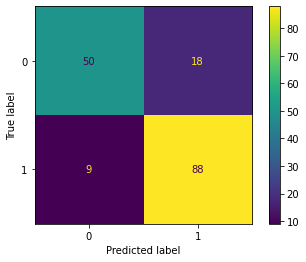

In [92]:
y_test_pred_knn = knn_gs.predict(X_test)
print(classification_report(y_test, y_test_pred_knn))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_knn);

In [93]:
x_error = X_test[y_test_pred_knn != y_test]
y_error = y_test[y_test_pred_knn != y_test]
p_error = y_test_pred_knn[y_test_pred_knn != y_test]

x_correct = X_test[y_test_pred_knn == y_test]
y_correct = y_test[y_test_pred_knn == y_test]
p_correct = y_test_pred_knn[y_test_pred_knn == y_test]

In [94]:
errordata_knn = {"Text": x_error, "True label": y_error, "Predicted label": p_error}
error_knn = pd.DataFrame(data=errordata_knn)

error_knn["Text length"] = error_knn["Text"].apply(lambda x: len(x.split(" ")))
average_length = error_knn["Text length"].mean()
print(min(error_knn["Text length"]))
print(average_length)
error_knn

38
329.51851851851853


,Text,True label,Predicted label,Text length
780,Lar Gand was born on Daxam in the 20th century...,0,1,98
1226,Courtney Whitmore is a junior member of the J...,0,1,926
1034,While performing experiments to contact altern...,0,1,78
550,After he was given the technology that kept hi...,0,1,385
1344,Ubu is the name given to several men who act a...,0,1,38
833,Madame Xanadu was once the sorceress Nimue Inw...,0,1,115
893,The origin others know: there are two differ...,0,1,1125
578,"The current Hawkgirl is Kendra Saunders, a you...",0,1,316
1036,"Born in 1914, Eugene Milton Judd was both a gi...",1,0,296
291,After discovering he had developed superpowers...,1,0,88


In [95]:
correctdata_knn = {"Text": x_correct, "True label": y_correct, "Predicted label": p_correct}
correct_knn = pd.DataFrame(data=correctdata_knn)

correct_knn["Text length"] = correct_knn["Text"].apply(lambda x: len(x.split(" ")))
average_length = correct_knn["Text length"].mean()
print(min(correct_knn["Text length"]))
print(average_length)
correct_knn

1
650.4202898550725


,Text,True label,Predicted label,Text length
330,"Crystalia ""Crystal"" Amaquelin is the princess ...",1,1,110
1340,Gotham City District Attorney Harvey Dent was ...,0,0,904
722,Karnak Mander-Azur is the second son of an Inh...,1,1,112
725,"Tatsu Yamashiro is Katana, a Japanese sword-wi...",0,0,51
340,Scott Summers was the first of two sons born...,1,1,1224
...,...,...,...,...
1210,Richard Parker was a scientist who was working...,1,1,242
144,Helena Wayne is the daughter of Bruce Wayne an...,0,0,77
462,Sam Wilson grew up in a tough Harlem neighbor...,1,1,595
534,Grant Douglas Ward grew up in Massachusetts an...,1,1,87


## 2.2 Support Vector Machines

In [96]:
print(svm_pipe.named_steps, "\n")
pp.pprint(sorted(svm_pipe.get_params().keys()))

{'tfidfvectorizer': TfidfVectorizer(max_features=500), 'maxabsscaler': MaxAbsScaler(), 'svc': SVC(random_state=32)} 

['maxabsscaler',
 'maxabsscaler__copy',
 'memory',
 'steps',
 'svc',
 'svc__C',
 'svc__break_ties',
 'svc__cache_size',
 'svc__class_weight',
 'svc__coef0',
 'svc__decision_function_shape',
 'svc__degree',
 'svc__gamma',
 'svc__kernel',
 'svc__max_iter',
 'svc__probability',
 'svc__random_state',
 'svc__shrinking',
 'svc__tol',
 'svc__verbose',
 'tfidfvectorizer',
 'tfidfvectorizer__analyzer',
 'tfidfvectorizer__binary',
 'tfidfvectorizer__decode_error',
 'tfidfvectorizer__dtype',
 'tfidfvectorizer__encoding',
 'tfidfvectorizer__input',
 'tfidfvectorizer__lowercase',
 'tfidfvectorizer__max_df',
 'tfidfvectorizer__max_features',
 'tfidfvectorizer__min_df',
 'tfidfvectorizer__ngram_range',
 'tfidfvectorizer__norm',
 'tfidfvectorizer__preprocessor',
 'tfidfvectorizer__smooth_idf',
 'tfidfvectorizer__stop_words',
 'tfidfvectorizer__strip_accents',
 'tfidfvectorizer__subline

In [97]:
svm_params = [{
    "tfidfvectorizer__analyzer": ["word", "char"],
    "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2,4)],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": [0.01, 0.1, 1],
    "svc__kernel": ["rbf", "sigmoid", "linear"]
    }]

In [98]:
svm_gs = GridSearchCV(svm_pipe, svm_params, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
svm_gs.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=500)),
                                       ('maxabsscaler', MaxAbsScaler()),
                                       ('svc', SVC(random_state=32))]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.1, 1, 10], 'svc__gamma': [0.01, 0.1, 1],
                          'svc__kernel': ['rbf', 'sigmoid', 'linear'],
                          'tfidfvectorizer__analyzer': ['word', 'char'],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                           (2, 4)]}],
             scoring='f1_macro', verbose=1)

In [99]:
svm_gs.best_score_

0.8469224955424229

In [100]:
svm_gs.best_params_

{'svc__C': 10,
 'svc__gamma': 0.1,
 'svc__kernel': 'rbf',
 'tfidfvectorizer__analyzer': 'char',
 'tfidfvectorizer__ngram_range': (1, 2)}

              precision    recall  f1-score   support

           0       0.77      0.85      0.81        68
           1       0.89      0.82      0.86        97

    accuracy                           0.84       165
   macro avg       0.83      0.84      0.83       165
weighted avg       0.84      0.84      0.84       165



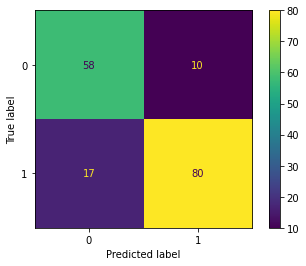

In [101]:
y_test_pred_svm = svm_gs.predict(X_test)
print(classification_report(y_test, y_test_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_svm);

In [102]:
x_error = X_test[y_test_pred_svm != y_test]
y_error = y_test[y_test_pred_svm != y_test]
p_error = y_test_pred_knn[y_test_pred_svm != y_test]

x_correct = X_test[y_test_pred_svm == y_test]
y_correct = y_test[y_test_pred_svm == y_test]
p_correct = y_test_pred_knn[y_test_pred_svm == y_test]

In [103]:
errordata_svm = {"Text": x_error, "True label": y_error, "Predicted label": p_error}
error_svm = pd.DataFrame(data=errordata_svm)

error_svm["Text length"] = error_svm["Text"].apply(lambda x: len(x.split(" ")))
average_length = error_svm["Text length"].mean()
print(min(error_svm["Text length"]))
print(average_length)
error_svm

38
265.962962962963


,Text,True label,Predicted label,Text length
1226,Courtney Whitmore is a junior member of the J...,0,1,926
1034,While performing experiments to contact altern...,0,1,78
633,"Robert Bruce Banner was born on Thursday, Dece...",1,1,309
550,After he was given the technology that kept hi...,0,1,385
1344,Ubu is the name given to several men who act a...,0,1,38
323,This robot construct of the Hulk was created a...,1,1,100
893,The origin others know: there are two differ...,0,1,1125
332,Cull Obsidian was physically the most powerful...,1,1,82
301,It is unknown exactly how old Clea is. Faltine...,1,1,229
1036,"Born in 1914, Eugene Milton Judd was both a gi...",1,0,296


In [104]:
correctdata_svm = {"Text": x_correct, "True label": y_correct, "Predicted label": p_correct}
correct_svm = pd.DataFrame(data=correctdata_svm)

correct_svm["Text length"] = correct_svm["Text"].apply(lambda x: len(x.split(" ")))
average_length = correct_svm["Text length"].mean()
print(min(correct_svm["Text length"]))
print(average_length)
correct_svm

1
662.8550724637681


,Text,True label,Predicted label,Text length
330,"Crystalia ""Crystal"" Amaquelin is the princess ...",1,1,110
1340,Gotham City District Attorney Harvey Dent was ...,0,0,904
722,Karnak Mander-Azur is the second son of an Inh...,1,1,112
725,"Tatsu Yamashiro is Katana, a Japanese sword-wi...",0,0,51
340,Scott Summers was the first of two sons born...,1,1,1224
...,...,...,...,...
1050,The ever-optimistic Maxwell Jordan was among t...,1,1,194
1210,Richard Parker was a scientist who was working...,1,1,242
144,Helena Wayne is the daughter of Bruce Wayne an...,0,0,77
462,Sam Wilson grew up in a tough Harlem neighbor...,1,1,595


## 2.3 Naive Bayes


In [105]:
print(nb_pipe.named_steps, "\n")
pp.pprint(sorted(nb_pipe.get_params().keys()))

{'tfidfvectorizer': TfidfVectorizer(max_features=500), 'maxabsscaler': MaxAbsScaler(), 'multinomialnb': MultinomialNB()} 

['maxabsscaler',
 'maxabsscaler__copy',
 'memory',
 'multinomialnb',
 'multinomialnb__alpha',
 'multinomialnb__class_prior',
 'multinomialnb__fit_prior',
 'steps',
 'tfidfvectorizer',
 'tfidfvectorizer__analyzer',
 'tfidfvectorizer__binary',
 'tfidfvectorizer__decode_error',
 'tfidfvectorizer__dtype',
 'tfidfvectorizer__encoding',
 'tfidfvectorizer__input',
 'tfidfvectorizer__lowercase',
 'tfidfvectorizer__max_df',
 'tfidfvectorizer__max_features',
 'tfidfvectorizer__min_df',
 'tfidfvectorizer__ngram_range',
 'tfidfvectorizer__norm',
 'tfidfvectorizer__preprocessor',
 'tfidfvectorizer__smooth_idf',
 'tfidfvectorizer__stop_words',
 'tfidfvectorizer__strip_accents',
 'tfidfvectorizer__sublinear_tf',
 'tfidfvectorizer__token_pattern',
 'tfidfvectorizer__tokenizer',
 'tfidfvectorizer__use_idf',
 'tfidfvectorizer__vocabulary',
 'verbose']


In [106]:
nb_params = [{
    "tfidfvectorizer__analyzer": ["word", "char"],
    "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2,4)],
    "multinomialnb__alpha": [0.5, 1, 10, 100]
    }]

In [107]:
nb_gs = GridSearchCV(nb_pipe, nb_params, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=1)
nb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=500)),
                                       ('maxabsscaler', MaxAbsScaler()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'multinomialnb__alpha': [0.5, 1, 10, 100],
                          'tfidfvectorizer__analyzer': ['word', 'char'],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                           (2, 4)]}],
             scoring='f1_macro', verbose=1)

In [108]:
nb_gs.best_score_

0.8627568113795305

In [109]:
nb_gs.best_params_

{'multinomialnb__alpha': 0.5,
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__ngram_range': (1, 2)}

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        68
           1       0.90      0.90      0.90        97

    accuracy                           0.88       165
   macro avg       0.87      0.87      0.87       165
weighted avg       0.88      0.88      0.88       165



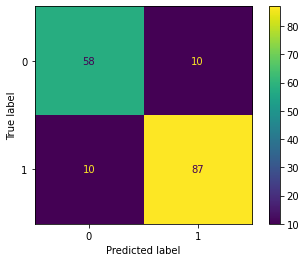

In [110]:
y_test_pred_nb = nb_gs.predict(X_test)
print(classification_report(y_test, y_test_pred_nb))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_nb);

In [111]:
x_error = X_test[y_test_pred_nb != y_test]
y_error = y_test[y_test_pred_nb != y_test]
p_error = y_test_pred_knn[y_test_pred_nb != y_test]

x_correct = X_test[y_test_pred_nb == y_test]
y_correct = y_test[y_test_pred_nb == y_test]
p_correct = y_test_pred_knn[y_test_pred_nb == y_test]

In [112]:
errordata_nb = {"Text": x_error, "True label": y_error, "Predicted label": p_error}
error_nb = pd.DataFrame(data=errordata_nb)

error_nb["Text length"] = error_nb["Text"].apply(lambda x: len(x.split(" ")))
average_length = error_nb["Text length"].mean()
print(min(error_nb["Text length"]))
print(average_length)
error_nb

33
165.35


,Text,True label,Predicted label,Text length
722,Karnak Mander-Azur is the second son of an Inh...,1,1,112
1034,While performing experiments to contact altern...,0,1,78
633,"Robert Bruce Banner was born on Thursday, Dece...",1,1,309
833,Madame Xanadu was once the sorceress Nimue Inw...,0,1,115
291,After discovering he had developed superpowers...,1,0,88
597,"Izaya, at this point known as Izaya the Inheri...",0,1,524
769,Algrim the Strong was one of the Dark Elves of...,1,1,35
904,Morse went to the S.H.I.E.L.D. Academy of Oper...,1,1,140
1228,Starro refers both to a starfish-shaped alien ...,0,1,65
1224,"Koriand'r (born November 11, 1991), anglicised...",0,0,82


In [113]:
correctdata_nb = {"Text": x_correct, "True label": y_correct, "Predicted label": p_correct}
correct_nb = pd.DataFrame(data=correctdata_svm)

correct_nb["Text length"] = correct_svm["Text"].apply(lambda x: len(x.split(" ")))
average_length = correct_nb["Text length"].mean()
print(min(correct_nb["Text length"]))
print(average_length)
correct_nb

1
662.8550724637681


,Text,True label,Predicted label,Text length
330,"Crystalia ""Crystal"" Amaquelin is the princess ...",1,1,110
1340,Gotham City District Attorney Harvey Dent was ...,0,0,904
722,Karnak Mander-Azur is the second son of an Inh...,1,1,112
725,"Tatsu Yamashiro is Katana, a Japanese sword-wi...",0,0,51
340,Scott Summers was the first of two sons born...,1,1,1224
...,...,...,...,...
1050,The ever-optimistic Maxwell Jordan was among t...,1,1,194
1210,Richard Parker was a scientist who was working...,1,1,242
144,Helena Wayne is the daughter of Bruce Wayne an...,0,0,77
462,Sam Wilson grew up in a tough Harlem neighbor...,1,1,595


## 3 Training: Neural networks

In [146]:
X_train = c_vect.fit_transform(X_train)
X_dev = c_vect.fit_transform(X_dev)
X_test = c_vect.fit_transform(X_test)

In [147]:
X_train = X_train.toarray()
X_dev = X_dev.toarray()
X_test = X_test.toarray()

In [157]:
# The labels are still Pandas.Series objects, which will conflict with PyTorch if not converted to arrays.
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

In [158]:
type(y_train)

numpy.ndarray

In [148]:
max_len = 500

# make sure that the sequences have the same size.
train_data = [sent[:max_len] for sent in X_train]
dev_data = [sent[:max_len] for sent in X_dev]
test_data = [sent[:max_len] for sent in X_test]

# To make the sequence the same size, we pad shorter sequences (shorter than 500) with zeroes.
x_train = pad_sequence([torch.tensor(sent) for sent in train_data], batch_first=True)
x_dev = pad_sequence([torch.tensor(sent) for sent in dev_data], batch_first=True)
x_test = pad_sequence([torch.tensor(sent) for sent in test_data], batch_first=True)

In [149]:
x_train[0][-110:]

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [150]:
max([len(x) for x in x_test])

500

In [165]:
min([len(x) for x in x_test])

500

In [159]:
x_train.shape, x_dev.shape, x_test.shape, y_train.shape, y_dev.shape, y_test.shape

(torch.Size([667, 500]),
 torch.Size([165, 500]),
 torch.Size([165, 500]),
 (667,),
 (165,),
 (165,))

In [160]:
def np2iter(x, y, shuffle=True):

  y = torch.tensor(y, dtype=torch.long)


  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=64, shuffle=shuffle)

train_iter = np2iter(x_train, y_train, shuffle=True)
dev_iter =  np2iter(x_dev, y_dev, shuffle=False)
test_iter =  np2iter(x_test, y_test, shuffle=False)

In [180]:
num_words = 5000

In [162]:
def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred=y_pred, y_true=y_test)

###3.2 LSTM

In [163]:
class LSTM(nn.Module):
  def __init__(self, emb_dim=50):
    super(LSTM, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words, 
                                   embedding_dim=emb_dim, padding_idx=0)
    
    self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=emb_dim, num_layers=1,
                      batch_first=True) # first dimension in (x, _) will be the batch size.
    # you can also call this layer self.lstm if it's more easier, but at the end it's still an RNN.
    
    self.linear_layer = nn.Linear(in_features=emb_dim, out_features=2)
    

  def forward(self, x):
    # our sequences have different lengths; let's calculate it
    len_x = (x !=0).sum(1)


    x = self.embeddings(x)

    # this function packs our padded sequences and later
    # makes sure that our RNNs do not read the padded part
    x = pack_padded_sequence(x, len_x.cpu(), batch_first=True, 
                             enforce_sorted=False)
    #  we extract the last hidden state
    _, (x, _) = self.rnn(x)
    x = x[0]
    return self.linear_layer(x)

In [164]:
lstm = LSTM(emb_dim=300)

lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.0001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

RuntimeError: ignored

I don't quite understand where the error comes from, but I will test a simple model to see if the error lies within the preprocessing or the model definition itself.

###3.3 Flat model

In [166]:
class FlatModel(nn.Module):
  def __init__(self, emb_dim=50):
    super(FlatModel, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words, 
                                   embedding_dim=emb_dim, padding_idx=0)
    
    self.layer = nn.Sequential(nn.Linear(in_features=emb_dim*max_len, out_features=emb_dim), 
                                nn.ReLU(),
                                nn.Linear(in_features=emb_dim, out_features=2))
    

  def forward(self, x):
    x = self.embeddings(x)
    x = torch.flatten(x, start_dim=1, end_dim=- 1)
    return self.layer(x)

In [167]:
flat_model = FlatModel(emb_dim=300) #300 embeddings
# we have sequences of 500 items. So we get a matrix of 300x500. This is stacked in one vector and is fed to the model.
flat_model = flat_model.cuda()

history = utils.train(model=flat_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(flat_model.parameters(), lr=0.0001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.7154 val_cls: 0.7120 val_acc: 0.5576
tensor(0.7120) None
epoch 2 train loss: 0.2598 val_cls: 0.8376 val_acc: 0.6000
tensor(0.8376) tensor(0.7120)
epoch 3 train loss: 0.1097 val_cls: 0.9964 val_acc: 0.6303
tensor(0.9964) tensor(0.7120)
epoch 4 train loss: 0.0576 val_cls: 1.0896 val_acc: 0.6364
tensor(1.0896) tensor(0.7120)
EARLY STOPPING 


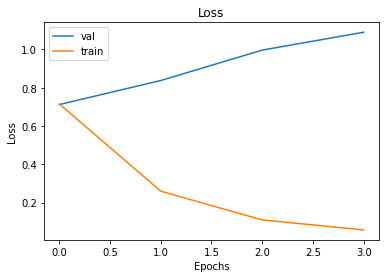

In [168]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [170]:
pred = utils.test(flat_model, test_iter)
pred = np.argmax(pred, axis=1)

print(accuracy_score(y_pred=pred, y_true=y_test))

0.5454545454545454


In [171]:
sum(p.numel() for p in flat_model.parameters() if p.requires_grad)

51000902

This works! Too bad it's a hopelessly overfitted garbage model.